# Hands-on example: mapping blood flow changes after MCAO (laser speckle data)

## Goals:
  - load MLF data
  - crop the area of interest and save as another sequence
  - make a movie
  - display overall CBF dynamics with time
  - calculate relative changes in blood flow
  - map these relative changes and look for peri-ischaemic zones
  - make nice plots in the process

First, we need to load importand modules and set up some display details:

In [1]:
%pylab qt
style.use('ggplot')
# This is just a custom plot style

from scipy import ndimage

import pandas as pd

import os.path

from imfun import fseq, lib, ui
rcParams['image.aspect']='equal'
rcParams['image.origin']='upper'
rcParams['figure.facecolor']='w'

from matplotlib import animation
#reload(animation)
animation.writers.list()

from imfun import filt

from matplotlib import rc

from pandas import ExcelWriter

def minute2ind(arr, dt):
    "for array (e.g. tranges) in minutes, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr*60/dt).astype(np.int)

def sec2ind(arr, dt):
    "for array (e.g. tranges) in sec, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr/dt).astype(np.int)

def minsec2mindec(arr):
    "for time in format min.sec, return min.dec eg. 2.30 = 2.50"
    return (int(arr) + ((arr % 1) / 0.6))

def ind2sec(arr, dt):
    "for array (e.g. tranges) in frame indices, return seconds, assuming dt is in seconds"
    return (arr*dt)

def ind2min(arr, dt):
    "for array (e.g. tranges) in frame indices, return minutes, assuming dt is in seconds"
    return int(arr * dt / 60)

def satisfies_keys(field, keys):
    """for each key check whether string `field` contains this key 
    if key is a string or any variants of the key if the key is a collection of strings"""
    res = True
    for key in keys:
        if isinstance(key, basestring):
            tmp = key in field
        else:
            tmp = np.any([(variant in field) for variant in key])
        res = res and tmp
        if not res: break
    return res

def smart_filter_columns(table, keys):
    if isinstance(table, pd.Series):
        index = table.index
    elif isinstance(table, pd.DataFrame):
        index = table.columns
    else:
        raise TypeError("Wrong table format") 
    cols = [c for c in index if satisfies_keys(c, keys)]
    return cols
            
#merge reps

def get_average_of_rep(serie):
    """find repeated stimulations in a pd.serie and return a serie 
    contaning the average of theese stimulations """
    roi_all = unique([c.split(':')[-1].strip() for c in x.columns])#['r01', 'r02', 'r03']
    freq_all = sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0])) #['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
    epo_all = unique([c.split(':')[0].strip() for c in x.columns]) #['epo1', 'epo2', 'epo3', 'epo4']
    average_results = pd.Series()    
    for roi in roi_all:
        for freq in freq_all:
            for epo in epo_all:
                test_rep = smart_filter_columns(serie, [roi, freq, epo])
                rep_n = len(test_rep)
                average = serie[test_rep].mean(axis=None, skipna=None, level=None, numeric_only=None)
                average_results[' : '.join((epo, freq, roi, 'rep_n=%d'%rep_n))] = average
    return average_results

def pixels2mm2(areas, pixel_size):
    "take a list of areas in number of pixels and converts them to mm^2"
    areas_mm2 = []
    for i in range(len(areas)):
        areas_mm2.append((np.sum(areas[i]) * (pixel_size ** 2)) / 1000000)
    return areas_mm2

def area_in_pixels(tranges, dt, level_of_interest):
    """take a list of frame sequenses(minutes), time between frames(s) and a tuple with the level of interest(%). 
    it returns a list of areas in pixels"""
    changes_after = []
    areas = []
    for i in range(len(tranges)):
        changes_after.append(fs2.mean_frame(minute2ind(tranges[i], dt)))
    for i in range(len(changes_after)):
        areas.append((level_of_interest[0] < changes_after[i]) * (changes_after[i] < level_of_interest[1]))
    return areas

def montage(ims, ncols, mask=None, **kwargs):
    style.use('ggplot')
    sh = ims[0].shape
    nrows = int(np.ceil(len(ims)/float(ncols)))
    out_shape = nrows*sh[0],ncols*sh[1]
    out = np.zeros(out_shape)
    if mask is not None:
        out_mask = np.zeros(out_shape, np.bool)

    imrows, imcols = sh
    
    
    for k, m in enumerate(ims):
        row_i,col_i = imrows*(k/ncols), imcols*(k%ncols)
        _slice = (slice(row_i,row_i+imrows), slice(col_i,col_i+imcols))
        out[_slice] = m
        if mask is not None:
            if np.ndim(mask) > 2 and k < len(mask):
                out_mask[_slice] = mask[k]
            else:
                out_mask[_slice] = mask
    if mask is not None:
        out = ma.masked_where(out_mask, out)        
    imshow(out, **kwargs)
    [axvline(x, color='white') for x in range(imcols,out_shape[1], imcols)]
    [axhline(x, color='white') for x in range(imrows,out_shape[0], imrows)]
    r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
    gca().add_patch(r)
    setp(gca(), xticks=[],yticks=[],frame_on=False)
    tight_layout()
    return out

def extract_roi_data():
    agg = []
    stim_freqs = epochs[0]
    print stim_freqs
    tvec = arange(-baseline_horizon, afterstim_horizon)
    for epnum,epoch in enumerate(epochs[1:]):
        for repnum, rep in enumerate(epoch):
            for t0,freq in zip(rep, stim_freqs):
                print t0,freq
                arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
                fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence
                p3 = ui.Picker(fs3_cut, verbose=False)
                p3.start()
                p3.load_rois(data_path+ '*.pickle')
                data = 100*array(p3.get_timeseries(normp=baseline_horizon))
                headers = [' : '.join(('epo%d'%(epnum+1), 'rep%d'%(repnum+1) ,'%dHz'%freq, tag)) for tag in p3.roi_tags()]
                x = pd.DataFrame({name:v for name,v in zip(headers, fs3)}, index=tvec)
                agg.append(x)
                close()
    return agg


Populating the interactive namespace from numpy and matplotlib
Can't load OpenCV python bindings No module named cv2


## Step 0. Load the data (run always)


<font color='red'>Choose your path to the data.

This way you read the file names with system (non-python) `ls` command and convert it to a python variable

In [2]:
animal_name = '041'
#data_path = '/home/data/MLauritzen-group/data-for-seminar/'
data_path = '/Users/cfw958/Desktop/lsi/'+animal_name+'/'

#data_path = 'smb://sundcifs12.sund.root.ku.dk/INF/NEUROFYSIOLOGI/TransNeuro/Jonas C. Fordsmann/Data pHd/Live Image Measurement-m125a-JCF-2015.mlf'
# at the moment, I have the data in Dropbox right here
#data_path = './'

#files = !ls /Users/cfw958/Desktop/lsi/*125.mlf
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
files = !ls {x + '*' + animal_name + '*.mlf'} # this is equivalent to the above
files

['/Users/cfw958/Desktop/lsi/041/Live Image Measurement041a.mlf',
 '/Users/cfw958/Desktop/lsi/041/Live Image Measurement041b.mlf',
 '/Users/cfw958/Desktop/lsi/041/Live Image Measurement041c.mlf',
 '/Users/cfw958/Desktop/lsi/041/Live Image Measurement041d.mlf']

<font color='red'>
  - Set ruler size in mm

  - The variable called 'of' (occlusion file) is the file number where you do the occlusion

  - put the number of files you want to merge (k=0 means 1 file)
  
  - Change the name so that it coresponde to the animal number
  
  - If you dont want the Improwed Lasso set improve_lasso to True
  
  - set limits for healthy, penumbra and core  as procentage of baseline before intervention (e.g. from 2o% to 50% of baseline would be (20, 50)


In [3]:
ruler_size = 3.55 # ruler size in mm (ruler  1 mm and gap between cranie edge where the gluebridge is = 3.55 mm) 
of = 1 #Select the occlusion file (2nd, with 'b')
k = 3
improve_lasso = False
name_cropped = animal_name+'-cropped.h5'
healthy = (50, 2000)
penumbra = (20, 50)
core = (0, 20)
crop_frame = False

In [4]:
name = files[of]
print 'occlusion file: ', name

# Create frame sequence objects from a list for file names 
fslist = [fseq.open_seq(name) for name in files]
dt, units = fslist[0].meta['axes'][0]
frame_rate = float(fslist[0].meta.get('axes')[0][0])
print 'frame rate = ' + str(frame_rate) + ' FPS'

occlusion file:  /Users/cfw958/Desktop/lsi/041/Live Image Measurement041b.mlf
frame rate = 1.0 FPS


<font color='red'>1) while cursor is over figure, press Shift to enable Lasso selector and right click and then rigth click and hold to draw around the area of interst
2) Draw line Roi

In [5]:
# Calculate average frame over first 60 seconds
mf = fslist[of].mean_frame(minute2ind(1, dt)) # First minute average

# Create a UI object and start it
p = ui.Picker(fslist[of]) #if you set a argument verbose = True inside brackets a manual get printet
p.start(mean_frame=mf, cmap='hot',vmax=1000) # I clip the values above 1000 for better vis.

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x1047a4e10>,
 <imfun.ui.Picker instance at 0x104289fc8>)

<font color='red'>If done before use the pixel_size according to output of this cell

In [6]:
# gets the length of a line roi put in a known distance to calculate pixel size

lengths = [r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)]
#lengths_as_dict = {tag:r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)}
#lengths_as_dict

#pixel_size = (ruler_size * 1000) / float(lengths[0]) # pixel size in um
# If done before use the following line to set pixel size according to output of this cell
pixel_size = 22.994563066
print 'ruler length = ' + str(lengths) + ' pixels'
print 'pixel size = ' + str(pixel_size) + ' um'

ruler length = [] pixels
pixel size = 22.994563066 um


# Step 1. Cropping

<font color='red'>**If you already cropped the frame and saved the concatenated-and-cropped frame sequence, skip this and proceed to Step2**

In [7]:
if crop_frame:
    savefig(data_path + 'raw_figure.pdf') #alternatively .png .svg . eps
    gcf()

We can continue with it, but we can also try to improve this a little bit with active contours:

In [8]:
# Import morphsnakes module if it's installed, install and import it otherwise
if crop_frame:
    if improve_lasso:
        try:
            import morphsnakes
        except ImportError:
            print "Don't have morphsnakes, installing"
            !pip install https://github.com/abrazhe/morphsnakes/zipball/master
            import morphsnakes

In [9]:
if crop_frame:
    if improve_lasso:
        reload(morphsnakes)
        figure()
        snake = morphsnakes.MorphACWE(mf,smoothing=3, lambda2=1.5, levelset=p.pmask)
        snake.run(50) # Run 50 or less iterations of MACWE algorithm

        imshow(mf, cmap='gray',vmax=1000); colorbar()
        contour(p.pmask, levels=[0],  colors=['g']) # starting contour
        contour(snake.levelset, levels=[0],  colors=['r']) # end contour
        savefig(data_path + 'Improved lasso crop.pdf')
        gcf()

**Exercise**: change number of iterations and values for `smoothing`, `lambda1`, and `lambda2` arguments and see what happens.

## Clip the data
Simple solution (no need to load all data to memory), also demonstrates why fseq.fns is there: 

Too much white, eh? On the brigth side, we don't have to load all the frames to do this.

It seems better to through away all unnecessary data and save the cropped sequence to an HDF5 format, so working with it later will be faster:

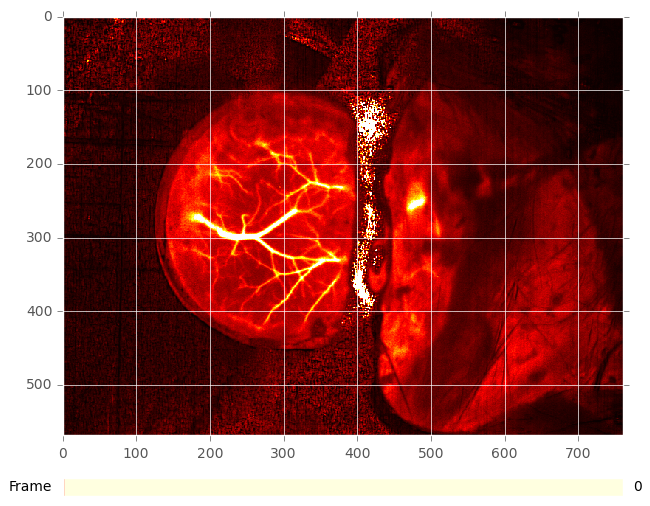

In [10]:
if crop_frame:
    print help(lib.embedding)
    fs = fslist[of]

    #pmask = snake.levelset # Comment this line if you didn't do the snakes
    pmask = p.pmask # Uncomment this if you didn't do the snakes

    func = lambda f: ma.masked_where(pmask == 0, f*pmask)

    f = fs[10] # take 11th frame from frame sequence
    lib.group_maps([f, func(f), lib.embedding(func(f))[0]], 
               titles=['raw', 'masked', 'cropped'],
               show_ticks = True)
    savefig(data_path + 'raw, masked, cropped.pdf')
gcf()

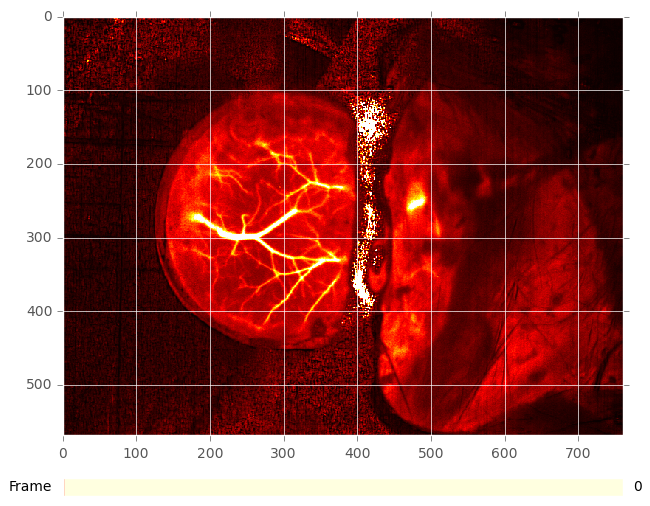

In [11]:
# we have to do embedding on the pmask, not each frame, to ensure the shape doesn't change
if crop_frame:
    _,(_,crop) = lib.embedding(pmask)

    print 'Cropping box:', crop

    fs = fslist[of]
    fs.fns = [lambda f: ma.masked_where(pmask==0, f*pmask), 
          lambda f: f[crop]]

    figure(10)
    imshow(fs.pipeline()(mf), vmax=1000,cmap='gray', extent = [0, (pixel_size * fs.shape()[1]), (pixel_size * fs.shape()[0]), 0])
    
    print fs[minute2ind(1, dt)].shape, fs.shape()
    savefig(data_path + 'cropping box.pdf')
gcf()

Apply the same processing pipline (a list of two functions applied to each frame in a sequence) to all loaded frame sequences (mlf files from the current experiment)

In [12]:
if crop_frame:
    pipeline = [lambda f: ma.masked_where(pmask==0, f*pmask), 
              lambda f: f[crop]]

    for seq in fslist:
        seq.fns = pipeline

In [13]:
# check that the pipeline makes sense for other frame sequences
if crop_frame:
    ui.Picker(fslist[k]).start(mean_frame=fslist[k].mean_frame(minute2ind(1, dt)), cmap='hot', vmax=1000,vmin=0)

In [14]:
if crop_frame:
    reload(fseq)

This is the actual conversion function. It returns a name of the new file. May be it would be better if it returned the new sequence instead?

In [15]:
if crop_frame:
    name2 = fseq.fseq2h5(fslist, data_path + name_cropped)
    print name2

# Step 2. Resting CBF

Note you have to create a variable called name2 with the name of the processed frame sequence (the one that end with '.h5')

Let's check that everything worked as expected, if the sequences are not aligned: one sees a double-image. This proves that the camera sadly have been moved during the recordings

In [16]:
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
name2 = !ls {x + '*.h5'} 
print name2
fs2 = fseq.open_seq(name2[0])
fs2.meta

fs2.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), 
                                       (pixel_size, 'um'),
                                       (pixel_size, 'um')])

print fs2.meta
print fs2.shape()

['/Users/cfw958/Desktop/lsi/041/041"2"-cropped.h5']
The file /Users/cfw958/Desktop/lsi/041/041"2"-cropped.h5 has the following data sets: [u'data']
{'axes': array([(1.0, 's'), (22.994563066, 'um'), (22.994563066, 'um')], 
      dtype=[('scale', '<f8'), ('units', 'S10')])}
(256, 217)


connecting callbacks to picker


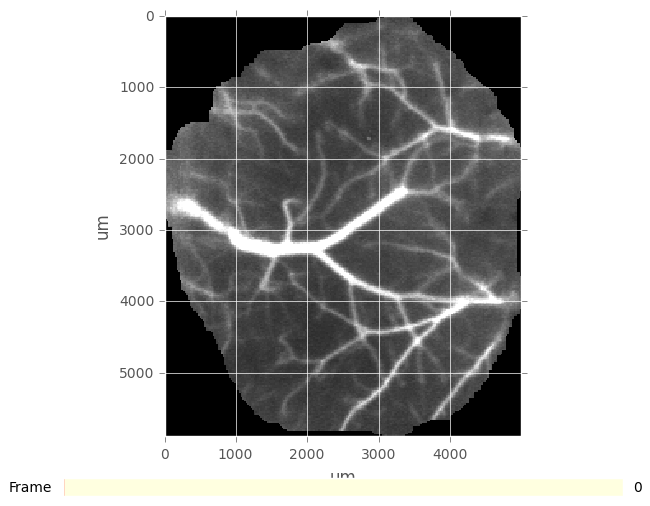

In [17]:
if len(fslist) > 1:   
    skip = len(fslist) and len(fslist[0]) or 0
    mf2 = fs2.mean_frame((skip, skip + minute2ind(1, dt)))
    p2 = ui.Picker(fs2); p2.start(mean_frame=mf2, cmap='gray',vmin=0, vmax=1000)    
else:
    print "There is nothing to merge"
gcf()

## Overall CBF dynamics

Small problem is, without going through the data, I don't know when MCAO was performed, so what to take as baseline and what time intervals to use for mapping. Let's find out by plotting interquartile range and the median of pixel intensities over time:

In [18]:
# Note I use list comprehesions all the time
fs2.fns = []
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2.frames()])

In [19]:
close('all')

Fsborders is: [1083 2934 6103 8872]


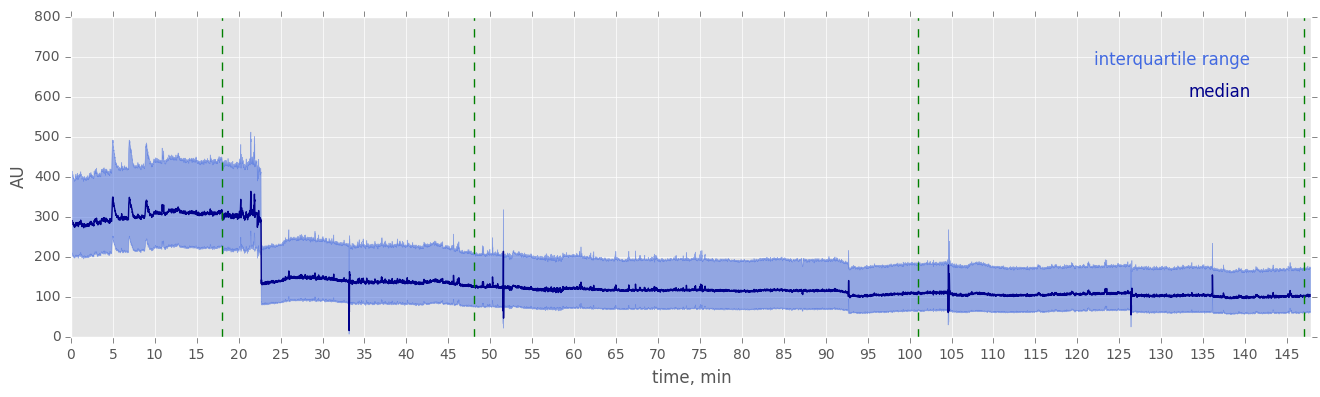

In [20]:
# time in minutes. If framerate is correctly set in fs2.meta, then
# fs2.frame_idx() returns time in seconds, we divide by 60 to convert to minutes
# if fs2.meta is not set, then frame_idx implies framerate is 1 Hz. This may be a problem
# if the framerate was different from 1 Hz.
t = fs2.frame_idx()/minute2ind(1, dt)

# borders between files
### 
fsborders = cumsum([len(fs) for fs in fslist]) #Run this if LSI files, if .h5 use next line with known values
#fsborders = [3310, 6659, 8922, 11344]
print 'Fsborders is:', fsborders

figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,800), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time, min',fontsize='large')
ylabel('AU',fontsize='large')

gcf()

**TODO**: add an interactive range picker

In [21]:
#description from log file
"""
Comments:

Purpose: Get baseline data for make MCAO el
… put tracheal tube + vein+artery catheter. 

Made craniotomy, placed LFP good responses. (slidely more medial)
Swicht alfa

LSI
First stim at 2.50 in LSI file a


Took a blood gas. 
 LSI gave Good responses
Made MCAO el at 3.00 and occluded at 4.40 in LSI file b (1:09:16 in spike file a)

perfect occlusion very medial penumba
loss of spontaneous activity
PID at ca 7.00 in medial rois in LSI file b (no clear dc)

Stim at 20.00 in LSI file b( no LFP, Attenuated but significant CBF responses)

Initial PID (no DC shift)

PID at ca 42.00 in medial rois in LSI file b (no clear dc)

LSI File c single points 5 sec delayed from LSI file 


PID at ca 45.00 in medial rois in LSI file c (no clear dc)

LSI file d start at 2:28:28
Stim at 13.30 in LSI file c( no LFP, Attenuated but significant CBF responses)


Stim at 35.35 in LSI file d( no LFP, Attenuated but significant CBF responses)

Took blood gas

2 HOUR WITH no reperfusion, no return of CBF response and NO LFP
"""

'\nComments:\n\nPurpose: Get baseline data for make MCAO el\n\xe2\x80\xa6 put tracheal tube + vein+artery catheter. \n\nMade craniotomy, placed LFP good responses. (slidely more medial)\nSwicht alfa\n\nLSI\nFirst stim at 2.50 in LSI file a\n\n\nTook a blood gas. \n LSI gave Good responses\nMade MCAO el at 3.00 and occluded at 4.40 in LSI file b (1:09:16 in spike file a)\n\nperfect occlusion very medial penumba\nloss of spontaneous activity\nPID at ca 7.00 in medial rois in LSI file b (no clear dc)\n\nStim at 20.00 in LSI file b( no LFP, Attenuated but significant CBF responses)\n\nInitial PID (no DC shift)\n\nPID at ca 42.00 in medial rois in LSI file b (no clear dc)\n\nLSI File c single points 5 sec delayed from LSI file \n\n\nPID at ca 45.00 in medial rois in LSI file c (no clear dc)\n\nLSI file d start at 2:28:28\nStim at 13.30 in LSI file c( no LFP, Attenuated but significant CBF responses)\n\n\nStim at 35.35 in LSI file d( no LFP, Attenuated but significant CBF responses)\n\nTook 

<font color='red'> 
Here you should put;
 - Occlusion time in minutes and sec(e.g. 3min 30sec = 3.30)
 - Baseline of 2 min and intervals of 2 min that you want to analyse. Format (1, 3) means from first min to third min of movie.
 - You can use fsboarder if useful. Remember to avoid stimulations.

In [22]:
occlusion_time_input = 22.50 # occlusion time in format min.sec (if more movies are merged you can use fsboarders)
#occlusion_time= ind2min(fsborders[0], dt) + minsec2mindec(07.00) #if more movies are merged you can use fsboarders stil in format min.sec

#translate occlusion time to decimal
occlusion_time = minsec2mindec(occlusion_time_input)#int(occlusion_time_input) + ((occlusion_time_input % 1) / 0.60) # occlusion time in minutes (decimal), dont change

#set tranges
#before_stim = (1, 3)
baseline = (15, 17)#(fsborders[0]/60.-2, fsborders[0]/60.+0) # # min 
interval_1 = (23, 25) #(occlusion_time + 0, occlusion_time + 2)#(occlusion_time, occlusion_time + 2) # min
interval_2 = (46.30, 48.38) #(occlusion_time + 8, occlusion_time + 10)#(fsborders[1]/60.-2, fsborders[1]/60.+0) #(occlusion_time + 8, occlusion_time + 10) #min
interval_3 = (100, 102) #(fsborders[2]/60.-2, fsborders[2]/60.+0) #(fsborders[1]/60.+11, fsborders[1]/60.+13) # min
interval_4 = (130, 132) #((ind2min(fsborders[2], dt) + minsec2mindec(05.00)), (ind2min(fsborders[2], dt) + minsec2mindec(07.00)))


#makes array of tranges (dont change)
tranges_min = np.array([baseline, interval_1, interval_2, interval_3, interval_4])
tranges_ind = minute2ind(tranges_min, dt)
#reperfusion_time = 42.63

step 2 basic ends here

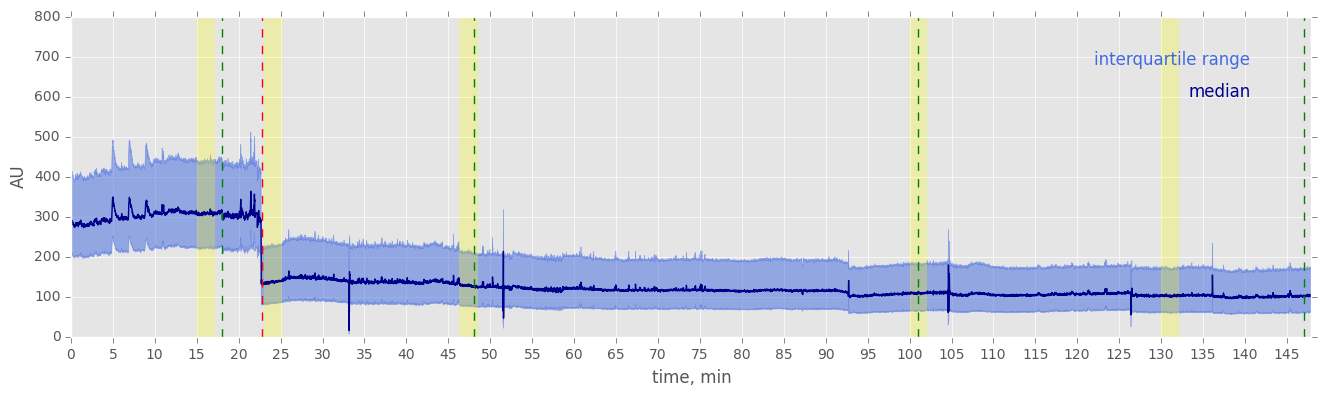

In [23]:
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')

draw()
gcf()

In [24]:
base_frame = fs2.mean_frame(tranges_ind[0]) # time-averaged frame over first of tranges

### <font color='blue'>Could be nice to be able to make a movie where 'no changes' shown as grey scale and changes above SD or 10 % shown as color scale)

Create a demonstration movie from the new frame sequence:
<font color='red'> 
Here you should put;
 - movie name
 - movie start
 - movie stop
 - set make movie to true if you want to make the movie
    

In [25]:
movie_name = animal_name + '-stim x20.mp4'
movie_start = ind2min(400, dt) #time in minutes
movie_stop = ind2min(550, dt) #time in minutes
fps = 20
make_movie = False

Don't run the following so far, as your system lacks `mencoder` or `avconv` and will instead try to create 8K images in your current folder.

In [26]:
if make_movie:
    fs2.export_movie_anim(data_path + movie_name, fig_size=(6,8), fps=fps, start = minute2ind(movie_start, dt), 
                          stop = minute2ind(movie_stop, dt), writer='ffmpeg', 
                          codec='h264',
                          cmap='jet',
                          vmin=0,vmax=1000)

## Calculate normalized CBF values in a lazy way

In [27]:
fs2.fns = [lambda f: np.where(base_frame>0, (100.*f)/base_frame, 0), 
           lambda f: ma.masked_where(base_frame <= 0, f)]
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2.frames()])

Now, show the new data:

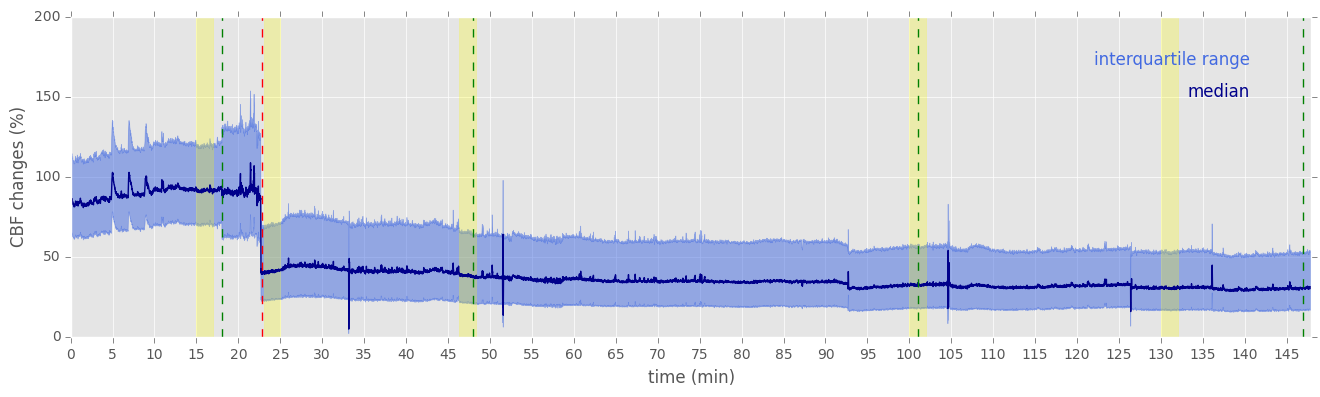

In [28]:
fig_handle = figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# average
#plot(t, frame_average, color = 'deeppink')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,200), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time (min)',fontsize='large')
ylabel('CBF changes (%)',fontsize='large')
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')
    
draw()

savefig(data_path + 'normalized_timecourse_figure.pdf') #alternatively .png .svg . eps

fig_handle

In [29]:
movie_name = 'test-movie-cbf-norm.mp4'
movie_start = 15 #time in minutes
movie_stop = 16 #time in minutes
fps = 10
make_movie = False

In [30]:
#fs2_norm = fs2
#penumbra_area = (penumbra[0] < fs2_norm) * (fs2_norm < penumbra[1])
#print penumbra_area
#print len(fs2_norm)
#fs2_norm.fns = [lambda f: ma.masked_where(-penumbra_area, f*fs2_norm)]
#fs2_norm
#fs2_norm_mask = ma.masked_where(-penumbra_area, fs2_norm)
#fs2_norm_mask

In [31]:
#if make_movie:
#    fs2_norm.export_movie_anim(data_path + movie_name, fig_size=(6,8), fps=fps, start = minute2ind(movie_start, dt), 
#                         stop = minute2ind(movie_stop, dt), writer='ffmpeg', 
#                         codec='h264',
#                         cmap='gray',
#                         vmin=0,vmax=1000)

In [32]:
changes = []
for trange in tranges_ind:
    changes.append(fs2.mean_frame(trange))

penumbra_areas_mask = []
for change in changes:
    penumbra_areas_mask.append((penumbra[0] < change) * (change < penumbra[1]))
    
core_areas_mask = []
for change in changes:
    core_areas_mask.append((core[0] < change) * (change < core[1]))
    
p2 = ui.Picker(fs2); p2.start(cmap='jet', vmin=10, vmax=110, mean_frame = changes[1])

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x118e10390>,
 <imfun.ui.Picker instance at 0x10378b680>)

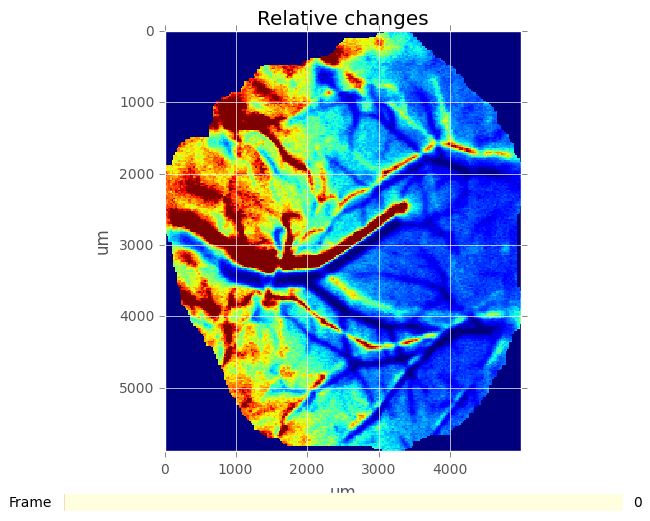

In [33]:
p2.fig.axes[0].set_title('Relative changes')
savefig(data_path + 'relative_changes_figure.pdf') #alternatively .png .svg . eps
gcf()

Lets calculate size of the different areas in mm^2

In [34]:
# Calulating area of craniotomy in um^2
craniotomy_area = area_in_pixels([tranges_min[0]], dt, (0, 2000))

# Calulating craniotomy area in um^2
craniotomy_area_mm2 = pixels2mm2(craniotomy_area, pixel_size)

print 'size craniotomy area = ' + str(craniotomy_area_mm2) + ' mm^2'

#mask penumbra for each of the tranges
penumbra_areas = area_in_pixels(tranges_min, dt, penumbra)

# Calulating areas of penumbra in um^2
penumbra_areas_mm2 = pixels2mm2(penumbra_areas, pixel_size)

print 'size penumbra areas = ' + str(penumbra_areas_mm2) + ' mm^2'

#mask core for each of the tranges
core_areas = area_in_pixels(tranges_min, dt, core)

# Calulating areas of core in um^2
core_areas_mm2 = pixels2mm2(core_areas, pixel_size)

print 'size core areas = ' + str(core_areas_mm2) + ' mm^2'

#mask healthy for each of the tranges
healthy_areas = area_in_pixels(tranges_min, dt, healthy)

# Calulating areas of healthy in um^2
healthy_areas_mm2 = pixels2mm2(healthy_areas, pixel_size)

print 'size healthy areas = ' + str(healthy_areas_mm2) + ' mm^2'

size craniotomy area = [22.902803243776628] mm^2
size penumbra areas = [0.0, 11.487092242203561, 11.161911034886867, 12.200375898577905, 12.160719653783186] mm^2
size core areas = [0.0, 1.6708497806841542, 2.3206834453869472, 3.4141383018599956, 4.1660207031678649] mm^2
size healthy areas = [22.902803243776628, 9.7448612208889127, 9.4202087635028136, 7.2882890433387288, 6.5760628868255786] mm^2


In [35]:
#make dataframe with all area data
time_lab = []
for r in tranges_min:
    time_lab.append("%0.0f to %0.0f min"%tuple(r - occlusion_time))

print time_lab

area_data = pd.DataFrame({'whole cranie (mm^2)':craniotomy_area_mm2, 'healthy (mm^2)':healthy_areas_mm2, 
                                       'penumbra (mm^2)':penumbra_areas_mm2, 
                                       'core (mm^2)':core_areas_mm2},
                                         index = time_lab)

area_data

['-8 to -6 min', '0 to 2 min', '23 to 26 min', '77 to 79 min', '107 to 109 min']


core (mm^2)  healthy (mm^2)  penumbra (mm^2)  \
-8 to -6 min       0.000000       22.902803         0.000000   
0 to 2 min         1.670850        9.744861        11.487092   
23 to 26 min       2.320683        9.420209        11.161911   
77 to 79 min       3.414138        7.288289        12.200376   
107 to 109 min     4.166021        6.576063        12.160720   

                whole cranie (mm^2)  
-8 to -6 min              22.902803  
0 to 2 min                22.902803  
23 to 26 min              22.902803  
77 to 79 min              22.902803  
107 to 109 min            22.902803

In [36]:
#normalise area results to whole cranie
area_data_norm = area_data / area_data.iloc[0]['whole cranie (mm^2)'] * 100

# renaming column names
area_data_norm.columns = ['core (%)', 'healthy (%)', 'penumbra (%)', 'whole cranie (%)']
area_data_norm

core (%)  healthy (%)  penumbra (%)  whole cranie (%)
-8 to -6 min     0.000000   100.000000      0.000000               100
0 to 2 min       7.295394    42.548771     50.155835               100
23 to 26 min    10.132748    41.131248     48.736004               100
77 to 79 min    14.907076    31.822694     53.270230               100
107 to 109 min  18.190003    28.712917     53.097080               100

In [37]:
#area_data_norm.rename(columns={'$a': 'a', '$b': 'b'}, inplace=True)
#area_data_norm

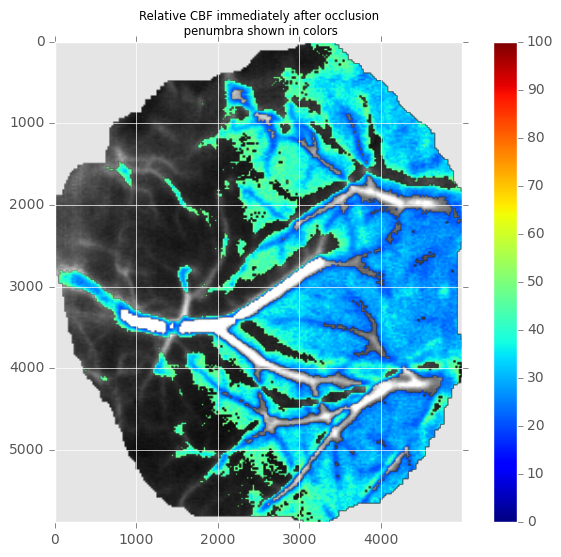

In [38]:
figure()

penumbra_area = (penumbra[0] < changes[1]) * (changes[1] < penumbra[1])

imshow(ma.masked_less_equal(base_frame, 0), cmap='gray',vmax=1000, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0])
imshow(ma.masked_where(-penumbra_area, changes[1]), vmin=0, vmax=100, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()
title('Relative CBF immediately after occlusion\n penumbra shown in colors',size='small')
savefig(data_path + 'relative_changes_masked_figure.pdf') #alternatively .png .svg . eps
gcf()

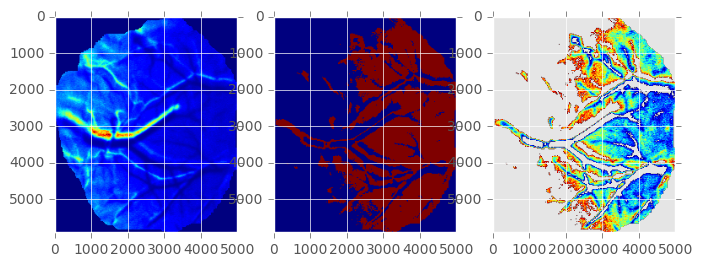

In [39]:
fs2.shape()
ma.masked_where(-penumbra_area, changes[1])

figure()
subplot(1,3,1)
imshow(changes[1], extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,2)
imshow(penumbra_area, extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,3)
imshow(ma.masked_where(-penumbra_area, changes[1]), extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])
gcf()

In [40]:
close ('all')

## Time-averaged maps

Again, I use list comprehensions. Now In also use a `map` function to apply my masking to each new array:

In [41]:
maps = map(fs2.fns[1], [fs2[x:y].mean(axis=0) for x,y in tranges_ind])
masks = [ma.masked_where((abs(m-100)<50)+(base_frame==0), m) for m in maps]

To show all maps together, we can define a convenience function, I'll call it `montage`:

**TODO** `montage` should be merged into `imfun.lib` in the future

Let's apply it and see what happens:

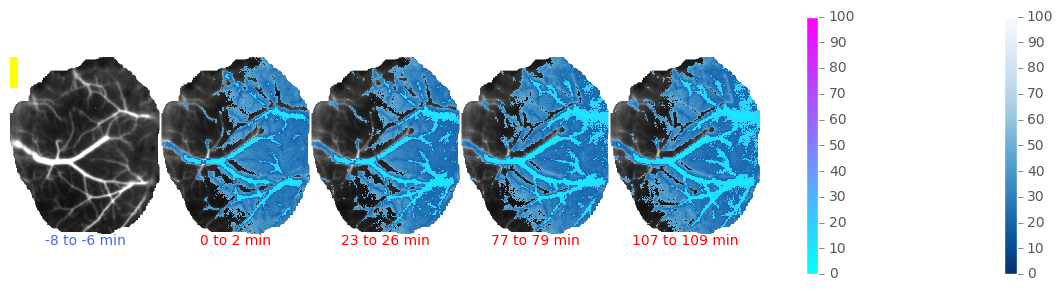

In [42]:
figure(figsize=(12,3))
neg_penumbra_areas_mask = [-x for x in penumbra_areas_mask]
neg_core_areas_mask = [-x for x in core_areas_mask]

bx = montage([base_frame]*len(maps),len(maps),mask=base_frame<=0,vmax=1000,cmap='gray')

x = montage(maps,len(maps),mask=(neg_penumbra_areas_mask)+(base_frame<=0),
            vmin = 0, vmax=100,interpolation='nearest', cmap = cm.Blues_r) #cm.Blues_r
colorbar()

cx = montage(maps,len(maps),mask=(neg_core_areas_mask)+(base_frame<=0),vmin = 0, vmax=100,interpolation='nearest', 
             cmap = 'cool')
colorbar()


h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+15, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

savefig(data_path + 'Time-averaged maps_figure.pdf') #alternatively .png .svg . eps    
gcf()

And as filled contours at user-specified levels:

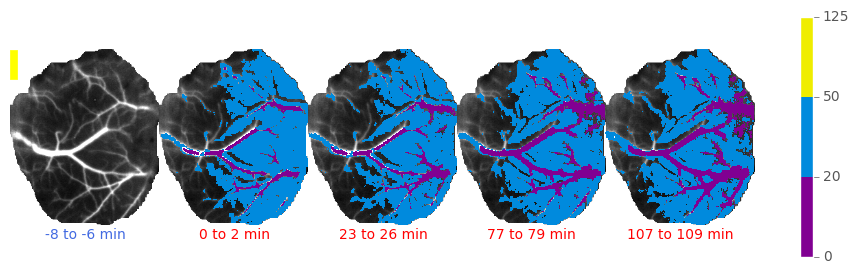

In [43]:

levels = [core[0], penumbra[0], penumbra[1], 125] # This value might be somewhat crazy
#extent = [0, (pixel_size * fs2.shape()[1]),(pixel_size * fs2.shape()[0]), 0]

f=figure(figsize=(12,3));
imshow(bx, cmap='gray', vmax=1000)

contourf(x, levels=levels, cmap='spectral'); #colorbar()
#x = montage(maps,len(maps),mask=(-penumbra_area)+(base_frame<=0),vmin = 0, vmax=150,interpolation='nearest'); colorbar()

contourf(cx, levels=levels, cmap='spectral'); colorbar()

setp(gca(), aspect='equal', xticks=[], yticks=[], frame_on=False)

h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+20, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
gca().add_patch(r)

savefig(data_path + 'Time-averaged maps_sharp_figure.pdf') #alternatively .png .svg . eps
gcf()

** Exercises: **
  2. Export relative changes as a movie
  3. How woudl you overlay the now-cropped mask on top of the full frame from the frame sequence we started with?

In [44]:
close('all')

# Step 3. Evoked CBF

## Evoked CBF responses

<font color='red'>Set values for the program; stim_freqs, nr, epoch_starts

In [45]:
#description from log file
"""
Comments:

Purpose: Get baseline data for make MCAO el
… put tracheal tube + vein+artery catheter. 

Made craniotomy, placed LFP good responses. (slidely more medial)
Swicht alfa

LSI
First stim at 2.50 in LSI file a


Took a blood gas. 
 LSI gave Good responses
Made MCAO el at 3.00 and occluded at 4.40 in LSI file b (1:09:16 in spike file a)

perfect occlusion very medial penumba
loss of spontaneous activity
PID at ca 7.00 in medial rois in LSI file b (no clear dc)

Stim at 20.00 in LSI file b( no LFP, Attenuated but significant CBF responses)

Initial PID (no DC shift)

PID at ca 42.00 in medial rois in LSI file b (no clear dc)

LSI File c single points 5 sec delayed from LSI file 


PID at ca 45.00 in medial rois in LSI file c (no clear dc)

LSI file d start at 2:28:28
Stim at 13.30 in LSI file c( no LFP, Attenuated but significant CBF responses)


Stim at 35.35 in LSI file d( no LFP, Attenuated but significant CBF responses)

Took blood gas

2 HOUR WITH no reperfusion, no return of CBF response and NO LFP
"""

'\nComments:\n\nPurpose: Get baseline data for make MCAO el\n\xe2\x80\xa6 put tracheal tube + vein+artery catheter. \n\nMade craniotomy, placed LFP good responses. (slidely more medial)\nSwicht alfa\n\nLSI\nFirst stim at 2.50 in LSI file a\n\n\nTook a blood gas. \n LSI gave Good responses\nMade MCAO el at 3.00 and occluded at 4.40 in LSI file b (1:09:16 in spike file a)\n\nperfect occlusion very medial penumba\nloss of spontaneous activity\nPID at ca 7.00 in medial rois in LSI file b (no clear dc)\n\nStim at 20.00 in LSI file b( no LFP, Attenuated but significant CBF responses)\n\nInitial PID (no DC shift)\n\nPID at ca 42.00 in medial rois in LSI file b (no clear dc)\n\nLSI File c single points 5 sec delayed from LSI file \n\n\nPID at ca 45.00 in medial rois in LSI file c (no clear dc)\n\nLSI file d start at 2:28:28\nStim at 13.30 in LSI file c( no LFP, Attenuated but significant CBF responses)\n\n\nStim at 35.35 in LSI file d( no LFP, Attenuated but significant CBF responses)\n\nTook 

spike file
<img src= 'spike overview' + animal_name + '.tiff'>

In [46]:
stim_freqs = [1, 2, 3, 5, 10] # Hz

nf = len(stim_freqs) # number of different stimulation frequencies( Hz)

nr = 1 # number of times the train is repeated
#nt = 3 # number of different timepoints we have recorded stimulations

epoch_starts = [minute2ind(minsec2mindec(2.50), dt), 
                int(fsborders[0]) + minute2ind(minsec2mindec(20.00), dt), 
                int(fsborders[2]) + minute2ind(minsec2mindec(13.30), dt), 
                int(fsborders[2]) + minute2ind(minsec2mindec(35.035), dt)]
                
                #int(fsborders[2]) + minute2ind(minsec2mindec(1.16), dt)]
#, 
                #int(fsborders[2]) + minute2ind(minsec2mindec(35.035), dt)] # first stimulation of each time point, can also be made in to a list
#epoch_starts = [0.45*1500, 9.41*1500, 39.13*1500, 48.19*1500, 71.91*1500, 81.40*1500] # first stimulation of each time point, can also be made in to a list

baseline_horizon = minute2ind(minsec2mindec(0.30), dt) # in frame counts (=seconds if Moor run in hi-res mode)
fnmap_horizon = minute2ind(minsec2mindec(0.30), dt) # in frame counts (=seconds if Moor run in hi-res mode)
afterstim_horizon = minute2ind(minsec2mindec(2.00), dt)
stim_sep = minute2ind(minsec2mindec(2.00), dt) # Interval between stimulations

print epoch_starts
epochs = [stim_freqs] + [[start + (nrep*nf*stim_sep)+stim_sep*arange(nf) for nrep in range(nr)] 
                         for start in epoch_starts]# array of stimulation onset times
epochs


[170, 2283, 6913, 8206]


[[1, 2, 3, 5, 10],
 [array([170, 290, 410, 530, 650])],
 [array([2283, 2403, 2523, 2643, 2763])],
 [array([6913, 7033, 7153, 7273, 7393])],
 [array([8206, 8326, 8446, 8566, 8686])]]

In [47]:
#If deletion of stims are necesary
epochs[3][2] = np.delete(epochs[3][2], 4)
epochs

IndexError: list index out of range

### Making functional map

In [48]:
t0 = epochs[1][0][1] # put in frame number of first stimulation
fs2.fns=[lambda f: filt.gauss_smooth(f)] 
bf = fs2.mean_frame([t0-baseline_horizon, t0])
sf = fs2.mean_frame([t0, t0+fnmap_horizon])
fm = 100*((sf/bf)-1)

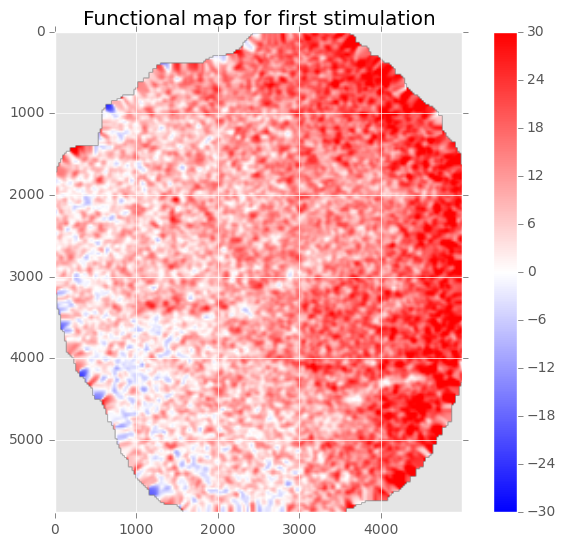

In [49]:
figure()
imshow(fm, vmax=30, vmin=-30, cmap=cm.bwr, extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0]); colorbar()
title('Functional map for first stimulation')
savefig(data_path + 'functional_map_figure.pdf')
gcf() 

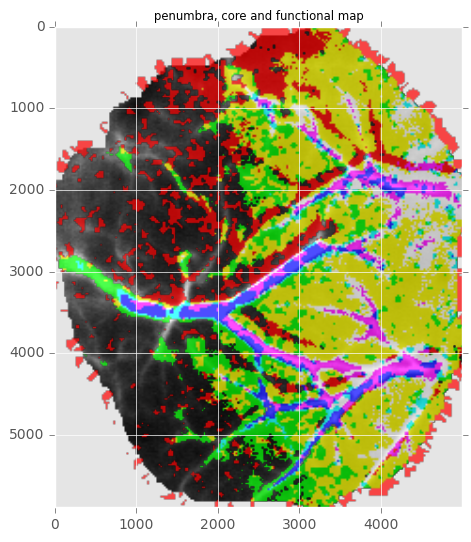

In [50]:
figure()
fm_cut = (10 < fm) * (fm < 30)

penumbra_area = (penumbra[0] < changes[1]) * (changes[1] < penumbra[1])

imshow(ma.masked_less_equal(base_frame, 0), cmap='gray',vmax=1000, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0])
#imshow(ma.masked_where(-penumbra_area, changes[1]), vmin=0, vmax=100, cmap = 'Greens', aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
#                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()
#imshow(ma.masked_where(-fm_cut, fm), vmin=0,alpha = 0.5, cmap = 'Reds', vmax=20, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
#                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()

z = zeros_like(fm_cut)

red_map = dstack([fm_cut, z, z, fm_cut])
green_map = dstack([z, penumbra_area, z, penumbra_area])
blue_map = dstack([z, z, core_areas[4], core_areas[4]])

imshow(clip(green_map + red_map + blue_map, 0, 1), aspect='equal',
       alpha = 0.7,
       extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])


title('penumbra, core and functional map',size='small')
savefig(data_path + 'penumbra, core and functional map_figure.pdf') #alternatively .png .svg . eps
gcf()

###### Making a frame sequense of the normalized evoked response

In [51]:
print data_path
name3 = !ls {data_path + '*.h5'} 
print name3
fs3 = fseq.open_seq(name3[0])
fs3.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), (pixel_size, 'um'), (pixel_size, 'um')])



/Users/cfw958/Desktop/lsi/041/
['/Users/cfw958/Desktop/lsi/041/041"2"-cropped.h5']
The file /Users/cfw958/Desktop/lsi/041/041"2"-cropped.h5 has the following data sets: [u'data']


In [52]:
arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence

In [53]:
base_frame = mean(arr[:30].astype(float), axis=0)
func_map = 100*(arr[30:]/base_frame - 1).mean(axis=0)

In [54]:
p3 = ui.Picker(fs3_cut)
p3.start(mean_frame = base_frame, vmax = 1000)

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x11a82c950>,
 <imfun.ui.Picker instance at 0x11add0f80>)

<font color='red'>Place rois in the functional area. two in penumbra and one in healthy tissue

In [55]:
if os.path.isfile(data_path+ animal_name + '-funcmap-rois.pickle'):
    p3.load_rois(data_path+ animal_name + '-funcmap-rois.pickle')
else:
    print 'place rois !!!'

<font color='red'>If you want to save another version of rois change data file name or reposition in picker

Saved ROIs to  /Users/cfw958/Desktop/lsi/041/041-funcmap-rois.pickle


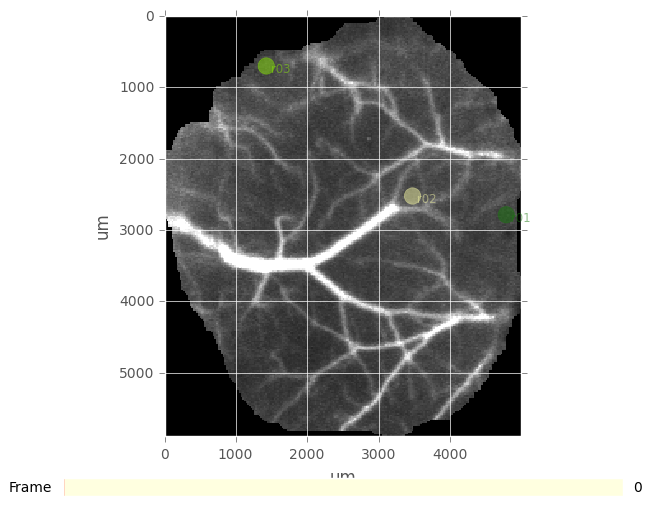

In [56]:
rois = p3.export_rois(data_path + animal_name +'-funcmap-rois.pickle') #
roi_file = animal_name + '-funcmap-rois.pickle'
savefig(data_path + 'roi_placement_figure.pdf')
gcf()

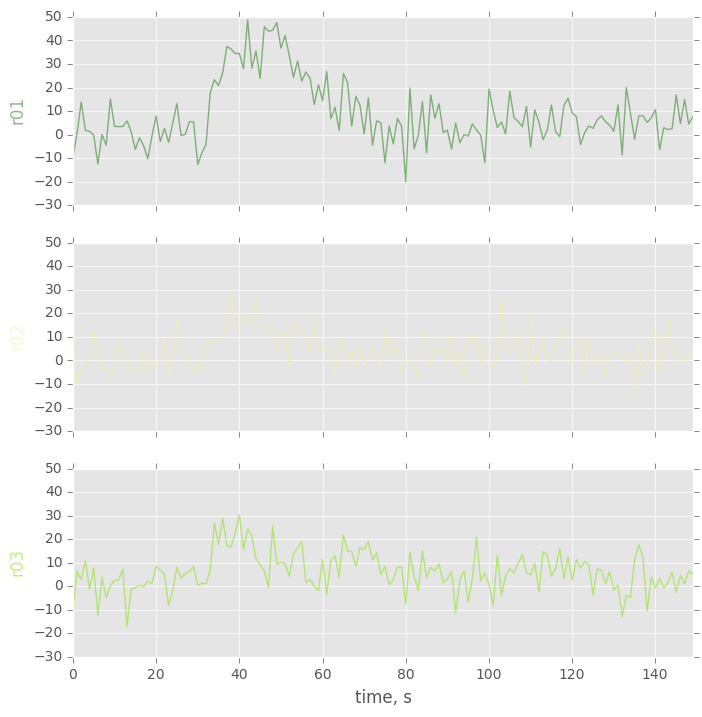

In [57]:
p3.show_zview(normp = lambda v: 100*(v/mean(1.0*v[:sec2ind(20, dt)]) -1)) # Show normalized time series from ROIs
f = gcf()
f.set_size_inches((8,8))
savefig(data_path + 'roi_single_stim_figure.pdf')
f

In [58]:
#resting CBF in ROIS
#take average of trange for each ROI and normalize to trange_min[0]

p4 = ui.Picker(fs3, verbose=False)
p4.start(mean_frame = base_frame, vmax = 1000)
p4.load_rois(data_path + roi_file)    

connecting callbacks to picker


In [59]:
data = p4.get_timeseries()

resting_cbf = pd.DataFrame()
for roi in range(len(rois)):
    time_series = pd.Series()
    mean_resting = []
    for trange in range(len(tranges_ind)):
        resting = (data[roi][tranges_ind[trange][0] : tranges_ind[trange][1]])
        mean_resting.append(resting.mean())
        norm_resting = 100 * mean_resting[trange] / mean_resting[0] 
        x = pd.Series(norm_resting, index = [time_lab[trange]]) 
        x.name = p3.roi_tags()[roi]
        time_series = time_series.append(x)
    resting_cbf = resting_cbf.append(time_series)
resting_cbf.to_csv(data_path+'resting CBF norm.csv')

resting_cbf = resting_cbf[time_lab]
resting_cbf.reindex([p3.roi_tags()])
resting_cbf

-8 to -6 min  0 to 2 min  23 to 26 min  77 to 79 min  107 to 109 min
r01           100   25.159638     23.273305     20.625702       19.613817
r03           100   43.453991     41.677349     38.889423       36.113297
r02           100   80.413853     68.372881     65.972308       66.484266

## Extracting data from many stimulations

In [60]:
def extract_roi_data():
    agg = []
    stim_freqs = epochs[0]
    print stim_freqs
    tvec = arange(-baseline_horizon, afterstim_horizon)
    for epnum,epoch in enumerate(epochs[1:]):
        for repnum, rep in enumerate(epoch):
            for t0,freq in zip(rep, stim_freqs):
                print t0,freq
                arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
                fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence
                p3 = ui.Picker(fs3_cut, verbose=False)
                p3.start()
                p3.load_rois(data_path + roi_file)
                data = 100*array(p3.get_timeseries(normp=baseline_horizon))
                headers = [' : '.join(('epo%d'%(epnum+1), 'rep%d'%(repnum+1) ,'%dHz'%freq, tag)) for tag in p3.roi_tags()]
                x = pd.DataFrame({name:v for name,v in zip(headers, data)}, index=tvec)
                agg.append(x)
                close()
    return agg

In [61]:
table = extract_roi_data()

[1, 2, 3, 5, 10]
170 1
connecting callbacks to picker
290 2
connecting callbacks to picker
410 3
connecting callbacks to picker
530 5
connecting callbacks to picker
650 10
connecting callbacks to picker
2283 1
connecting callbacks to picker
2403 2
connecting callbacks to picker
2523 3
connecting callbacks to picker
2643 5
connecting callbacks to picker
2763 10
connecting callbacks to picker
6913 1
connecting callbacks to picker
7033 2
connecting callbacks to picker
7153 3
connecting callbacks to picker
7273 5
connecting callbacks to picker
7393 10
connecting callbacks to picker
8206 1
connecting callbacks to picker
8326 2
connecting callbacks to picker
8446 3
connecting callbacks to picker
8566 5
connecting callbacks to picker
8686 10
connecting callbacks to picker


In [62]:
x = pd.concat(table, axis=1) # stack columns
x.to_csv(data_path+'raw stimulations.csv')

In [63]:
x.keys()

Index([ u'epo1 : rep1 : 1Hz : r01',  u'epo1 : rep1 : 1Hz : r02',
        u'epo1 : rep1 : 1Hz : r03',  u'epo1 : rep1 : 2Hz : r01',
        u'epo1 : rep1 : 2Hz : r02',  u'epo1 : rep1 : 2Hz : r03',
        u'epo1 : rep1 : 3Hz : r01',  u'epo1 : rep1 : 3Hz : r02',
        u'epo1 : rep1 : 3Hz : r03',  u'epo1 : rep1 : 5Hz : r01',
        u'epo1 : rep1 : 5Hz : r02',  u'epo1 : rep1 : 5Hz : r03',
       u'epo1 : rep1 : 10Hz : r01', u'epo1 : rep1 : 10Hz : r02',
       u'epo1 : rep1 : 10Hz : r03',  u'epo2 : rep1 : 1Hz : r01',
        u'epo2 : rep1 : 1Hz : r02',  u'epo2 : rep1 : 1Hz : r03',
        u'epo2 : rep1 : 2Hz : r01',  u'epo2 : rep1 : 2Hz : r02',
        u'epo2 : rep1 : 2Hz : r03',  u'epo2 : rep1 : 3Hz : r01',
        u'epo2 : rep1 : 3Hz : r02',  u'epo2 : rep1 : 3Hz : r03',
        u'epo2 : rep1 : 5Hz : r01',  u'epo2 : rep1 : 5Hz : r02',
        u'epo2 : rep1 : 5Hz : r03', u'epo2 : rep1 : 10Hz : r01',
       u'epo2 : rep1 : 10Hz : r02', u'epo2 : rep1 : 10Hz : r03',
        u'epo3 : rep1 : 1

In [64]:
x.describe()

epo1 : rep1 : 1Hz : r01  epo1 : rep1 : 1Hz : r02  \
count               150.000000               150.000000   
mean                  3.022462                 1.511817   
std                   6.818812                 7.019953   
min                 -13.670445               -17.689258   
25%                  -1.178660                -3.077438   
50%                   2.659062                 1.362406   
75%                   8.147004                 6.587736   
max                  17.726917                21.753553   

       epo1 : rep1 : 1Hz : r03  epo1 : rep1 : 2Hz : r01  \
count               150.000000               150.000000   
mean                  1.164226                 7.831282   
std                   5.888452                13.485027   
min                 -18.984570               -20.955831   
25%                  -2.756039                -0.798848   
50%                   0.322026                 4.242720   
75%                   4.890477                14.122660   
max                  18.362756                47.257443   

       epo1 : rep1 : 2Hz : r02  epo1 : rep1 : 2Hz : r03  \
count               150.000000               150.000000   
mean                  4.739365                 3.626022   
std                   8.272753                 7.677800   
min                 -18.386508               -14.511010   
25%                  -0.296231                -2.190401   
50%                   4.428010                 2.823221   
75%                   9.495427                 8.654616   
max                  28.485985                28.551272   

       epo1 : rep1 : 3Hz : r01  epo1 : rep1 : 3Hz : r02  \
count               150.000000               150.000000   
mean                  8.282333                 3.282973   
std                  12.219007                 8.186722   
min                 -13.420793               -15.581582   
25%                   0.540221                -2.035839   
50%                   4.929049                 3.107033   
75%                  12.954462                 7.714600   
max                  47.181535                26.537863   

       epo1 : rep1 : 3Hz : r03  epo1 : rep1 : 5Hz : r01  \
count               150.000000               150.000000   
mean                  2.352329                 6.551497   
std                   7.377221                10.922023   
min                 -15.816178               -16.286113   
25%                  -2.302579                -1.361676   
50%                   1.151185                 4.614866   
75%                   5.854606                13.323784   
max                  25.495481                44.612864   

                 ...             epo4 : rep1 : 2Hz : r03  \
count            ...                          150.000000   
mean             ...                           -0.834877   
std              ...                            7.957476   
min              ...                          -20.597863   
25%              ...                           -6.614670   
50%              ...                           -1.092627   
75%              ...                            3.847576   
max              ...                           20.098315   

       epo4 : rep1 : 3Hz : r01  epo4 : rep1 : 3Hz : r02  \
count               150.000000               150.000000   
mean                  2.088570                -0.927451   
std                   9.935414                 7.171273   
min                 -21.822165               -19.613544   
25%                  -4.973310                -6.520898   
50%                   1.688607                -1.085527   
75%                   8.887518                 4.222168   
max                  31.707110                15.910372   

       epo4 : rep1 : 3Hz : r03  epo4 : rep1 : 5Hz : r01  \
count               150.000000               150.000000   
mean                  1.749887                 2.209799   
std                   8.353435                 9.849461   
min                 -21.081836        

As an example, let's plot all time points for a specific frequency and roi number. We will generalize and make it a function later.

In [65]:
print 'valid rois:', unique([c.split(':')[-1].strip() for c in x.columns])
print 'valid epo:', unique([c.split(':')[0].strip() for c in x.columns])
print 'valid freq:', sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0]))

valid rois: [u'r01' u'r02' u'r03']
valid epo: [u'epo1' u'epo2' u'epo3' u'epo4']
valid freq: [u'1Hz', u'2Hz', u'3Hz', u'5Hz', u'10Hz']


<font color='red'>Set stimulation of interest

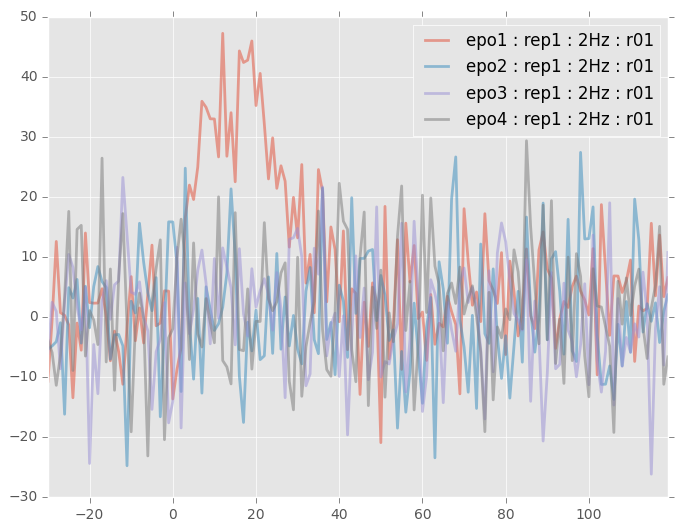

In [67]:

roi = ['r01']
freq = ['2Hz']
epo = ['epo1', 'epo2', 'epo3', 'epo4']
rep = ['rep1']

#cols = [c for c in x.columns if satisfies_keys(c, [roi, freq, epo, rep])]
cols = smart_filter_columns(x, [roi, freq, epo, rep])

#show raw
x[cols].plot(lw=2, alpha=0.5)
gcf()

Lets apply a running average to all the stimulations

In [68]:
xsmooth = pd.rolling_mean(x, 3, min_periods=None, freq=None, center=False, how=None)

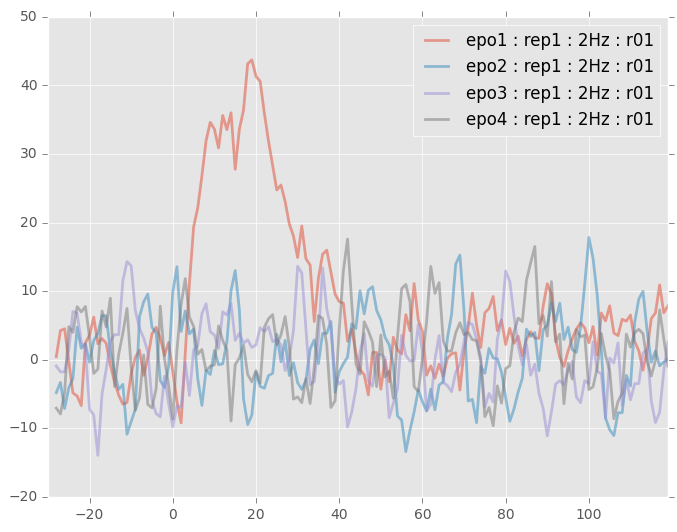

In [69]:
#show smooth
xsmooth[cols].plot(lw=2, alpha=0.5, legend=True)
savefig(data_path + 'timepoints_stimulations_figure.pdf')
gcf()

In [70]:
print xsmooth.size
close('all')

9000


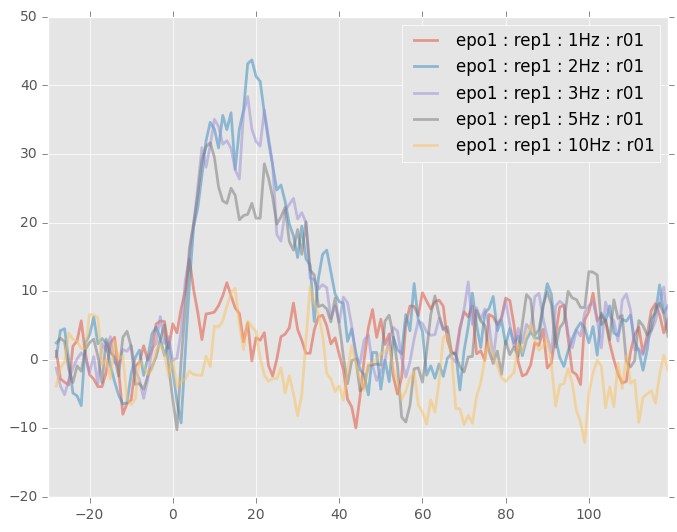

In [71]:
all_freqs_before = smart_filter_columns(xsmooth, [['r01'], ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz'], ['rep1'], ['epo1']])
xsmooth[all_freqs_before].plot(lw=2, alpha=0.5, legend=True)
savefig(data_path + 'frequencies_stimulations_figure.pdf')
gcf()

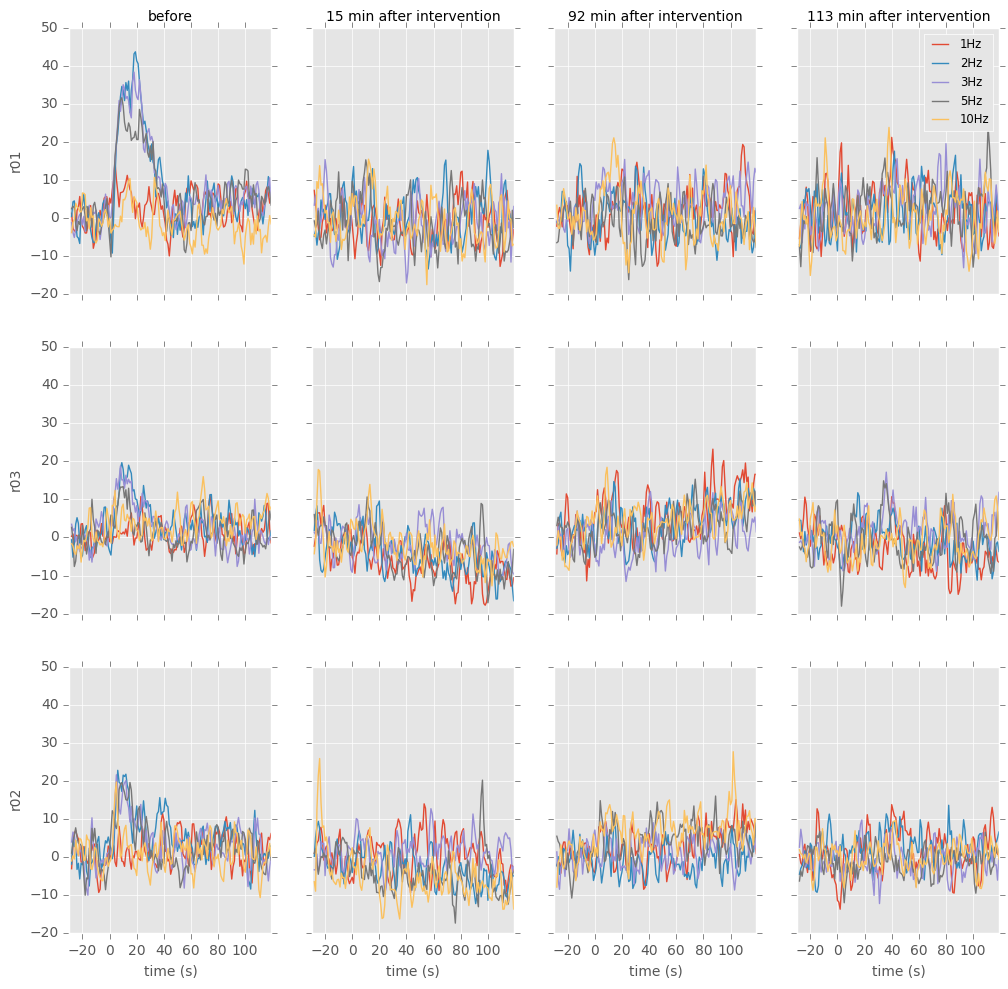

In [72]:
#show rep 1
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep1'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep1.pdf')
gcf()

In [73]:
xsmooth_exclude = xsmooth.copy(deep=True)

In [74]:
#exclude specific traces
#del xsmooth_exclude['epo2 : rep1 : 1Hz : r01']
#del xsmooth_exclude['epo3 : rep1 : 10Hz : r01']
#del xsmooth_exclude['epo3 : rep1 : 2Hz : r02']

In [75]:
print xsmooth.size
print xsmooth_exclude.size

9000
9000


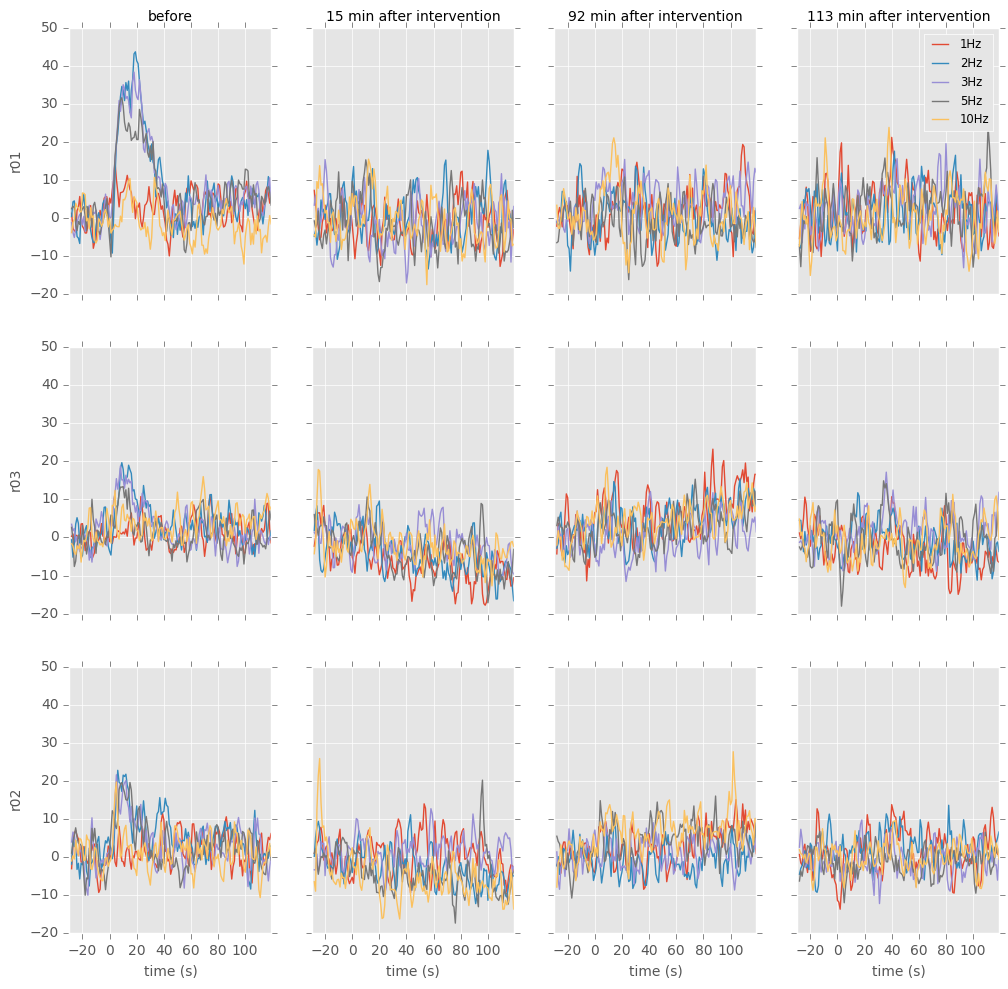

In [76]:
#show rep 1 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep1'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep1_with_exclusion.pdf')
gcf()

In [77]:
#show rep 2
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep2'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep2.pdf')
gcf()

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
#exclude specific traces
#del xsmooth_exclude['epo3 : rep2 : 2Hz : r01']
#del xsmooth_exclude['epo3 : rep2 : 2Hz : r04']

print xsmooth.size
print xsmooth_exclude.size

In [ ]:
#show rep 2 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep2'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)

savefig(data_path + 'all_stimulations_figure_rep2_with_exclusion.pdf')
gcf()

In [ ]:
#show rep 3
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth, [roi, 'epo%d'%(col+1), 'rep3'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep3.pdf')
gcf()

In [ ]:
#exclude specific traces
#del xsmooth_exclude['epo3 : rep3 : 2Hz : r01']
#del xsmooth_exclude['epo3 : rep3 : 2Hz : r04']

print xsmooth.size
print xsmooth_exclude.size

In [ ]:
#show rep 3 with exclusion
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
reps = ['rep1']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(xsmooth_exclude, [roi, 'epo%d'%(col+1), 'rep3'])
        subtable = xsmooth[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_rep3_with_exclusion.pdf')
gcf()

In [78]:
def get_average_of_trace(dataframe):
    """find repeated stimulations in a pd.dataframe and return a dataframe 
    contaning the average,sd and sem of theese stimulations """
    roi_all = unique([c.split(':')[-1].strip() for c in x.columns])#['r01', 'r02', 'r03']
    print roi_all
    freq_all = sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0])) #['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
    print freq_all
    epo_all = unique([c.split(':')[0].strip() for c in x.columns]) #['epo1', 'epo2', 'epo3', 'epo4']
    print epo_all
    average_results = pd.DataFrame()    
    for roi in roi_all:
        for freq in freq_all:
            for epo in epo_all:
                test_rep = smart_filter_columns(dataframe, [roi, freq, epo])
                rep_n = len(test_rep)
                average = dataframe[test_rep].mean(axis=1, skipna=None, level=None, numeric_only=None)
                sd = dataframe[test_rep].mean(axis=1, skipna=None, level=None, numeric_only=None)
                average_results[' : '.join((epo, freq, roi, 'rep_n=%d'%rep_n))] = average
    return average_results

In [79]:
test = get_average_of_trace(xsmooth_exclude)

[u'r01' u'r02' u'r03']
[u'1Hz', u'2Hz', u'3Hz', u'5Hz', u'10Hz']
[u'epo1' u'epo2' u'epo3' u'epo4']


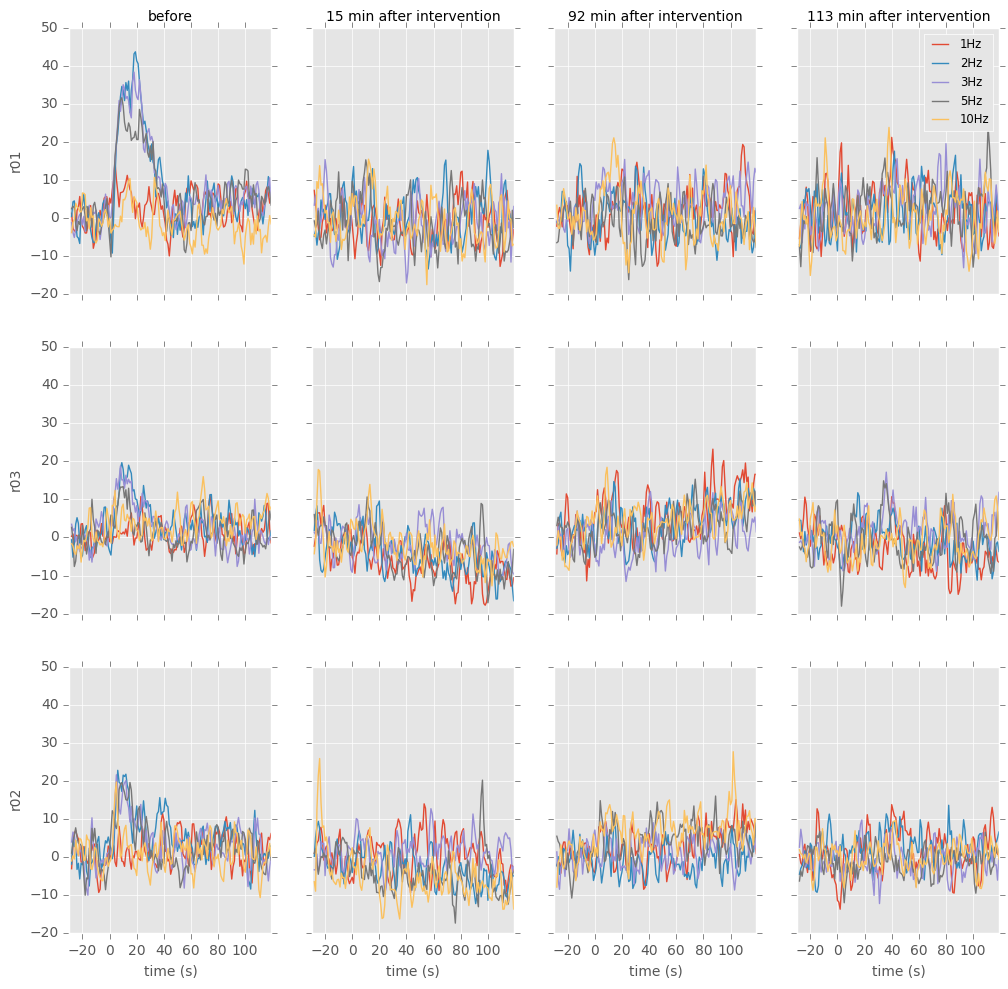

In [80]:
#show average traces of reps, add SEM or SD
rc('legend', fontsize='small')
           
freqs = ['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
roi_labels = [r['label']  for r in rois]
time_label = 'time (s)'

epo_name = ['before']

for epo in range(len(epochs[2:])):
    epo_name.append(str(int(ind2min(epochs[epo+2][0][0], dt) - occlusion_time)) + ' min after intervention')
    
fig, axs = subplots(nrows = len(rois), ncols = len(epochs)-1, sharex = True, sharey = True, figsize=(12,12))
for row, roi in enumerate(roi_labels):
    for col in range(len(epochs[1:])):
        filteredcols = smart_filter_columns(test, [roi, 'epo%d'%(col+1)])
        subtable = test[filteredcols]
        subtable.plot(ax = axs[row, col], legend=False)
        if row == 0:
            axs[row,col].set_title(epo_name[col], fontsize=10)
            if col == len(epochs[1:])-1:
                axs[row,col].legend(freqs)
        if col == 0:
            axs[row,col].set_ylabel(roi_labels[row], fontsize=10)
        if row == 2:
            axs[row,col].set_xlabel('time (s)', fontsize=10)
savefig(data_path + 'all_stimulations_figure_avr_reps.pdf')
gcf()

In [81]:
#set time of interest
toi = xsmooth_exclude.iloc[30:50] 

# calculates parameters
peak = toi.max(axis=None, skipna=None, level=None, numeric_only=None) #(% of baseline)
mean = toi.mean(axis=None, skipna=None, level=None, numeric_only=None) #(AU)
ttp = ind2sec(toi.idxmax(axis=0, skipna=True), dt) # (s)  

results = pd.DataFrame({'peak (%)':peak, 'mean (%)':mean, 'ttp (s)':ttp})
results

mean (%)   peak (%)  ttp (s)
epo1 : rep1 : 1Hz : r01    7.084355  14.664735        4
epo1 : rep1 : 1Hz : r02    0.772300   8.014120        7
epo1 : rep1 : 1Hz : r03    1.148902   6.436815       16
epo1 : rep1 : 2Hz : r01   24.219265  43.724552       19
epo1 : rep1 : 2Hz : r02   12.722842  22.770842        6
epo1 : rep1 : 2Hz : r03   10.994589  19.675829        9
epo1 : rep1 : 3Hz : r01   24.572764  38.372721       18
epo1 : rep1 : 3Hz : r02   11.995145  21.597144        5
epo1 : rep1 : 3Hz : r03   11.803162  18.801443        8
epo1 : rep1 : 5Hz : r01   18.929101  31.637606        9
epo1 : rep1 : 5Hz : r02   12.496921  19.569318       15
epo1 : rep1 : 5Hz : r03    7.417974  13.378149       10
epo1 : rep1 : 10Hz : r01   2.084757  10.404008       15
epo1 : rep1 : 10Hz : r02   4.325037  19.704371        5
epo1 : rep1 : 10Hz : r03   4.641284  12.360352        4
epo2 : rep1 : 1Hz : r01   -1.811296   5.566558        7
epo2 : rep1 : 1Hz : r02    1.086969   7.035591       12
epo2 : rep1 : 1Hz : r03   -3.365966   3.300404        9
epo2 : rep1 : 2Hz : r01    1.977183  13.554930        1
epo2 : rep1 : 2Hz : r02    0.015695   6.838752        5
epo2 : rep1 : 2Hz : r03   -0.399081   8.597374       19
epo2 : rep1 : 3Hz : r01    0.407426  10.697341        9
epo2 : rep1 : 3Hz : r02    2.928470  10.086208        3
epo2 : rep1 : 3Hz : r03    0.285855   8.630332        5
epo2 : rep1 : 5Hz : r01    3.607222  15.313658       10
epo2 : rep1 : 5Hz : r02   -3.146163   1.819958        1
epo2 : rep1 : 5Hz : r03    1.693658  10.663944       11
epo2 : rep1 : 10Hz : r01   5.113653  15.486211       12
epo2 : rep1 : 10Hz : r02  -1.131206   7.679635       13
epo2 : rep1 : 10Hz : r03   2.638237  13.965687       13
epo3 : rep1 : 1Hz : r01    0.530496   9.373968       17
epo3 : rep1 : 1Hz : r02    2.331563   9.312075        8
epo3 : rep1 : 1Hz : r03    9.100349  17.627242       16
epo3 : rep1 : 2Hz : r01    1.707197   8.217307       14
epo3 : rep1 : 2Hz : r02   -0.677044   9.098567       15
epo3 : rep1 : 2Hz : r03    3.548848  14.702839       14
epo3 : rep1 : 3Hz : r01    6.710085  13.345497        6
epo3 : rep1 : 3Hz : r02    2.058698   8.601366        8
epo3 : rep1 : 3Hz : r03   -0.873279   9.635441       12
epo3 : rep1 : 5Hz : r01    1.074842   8.393657       16
epo3 : rep1 : 5Hz : r02    5.124808  14.792038        4
epo3 : rep1 : 5Hz : r03    3.395113   9.928485       10
epo3 : rep1 : 10Hz : r01   9.480502  21.104074       14
epo3 : rep1 : 10Hz : r02   7.788579  13.735438       11
epo3 : rep1 : 10Hz : r03   5.023457  18.463285        9
epo4 : rep1 : 1Hz : r01    2.845154  19.789326        3
epo4 : rep1 : 1Hz : r02   -2.620719   4.978193       17
epo4 : rep1 : 1Hz : r03   -2.048937   5.653205       19
epo4 : rep1 : 2Hz : r01    0.967261  11.850459        3
epo4 : rep1 : 2Hz : r02    1.710148   6.914809       16
epo4 : rep1 : 2Hz : r03   -0.278232  11.774920       15
epo4 : rep1 : 3Hz : r01   -0.156668   9.844538        2
epo4 : rep1 : 3Hz : r02   -1.188221   9.711153       18
epo4 : rep1 : 3Hz : r03   -0.817605   3.891741       18
epo4 : rep1 : 5Hz : r01    0.602414  10.625102       19
epo4 : rep1 : 5Hz : r02   -3.534736   1.713791       19
epo4 : rep1 : 5Hz : r03   -1.522613   9.858189        0
epo4 : rep1 : 10Hz : r01  -2.180319   5.053321       11
epo4 : rep1 : 10Hz : r02  -1.452958   6.890333       13
epo4 : rep1 : 10Hz : r03  -3.570438   3.205994        5

In [82]:
average_of_rep_results = pd.DataFrame({'peak avr (%)':get_average_of_rep(peak), 
                                       'mean avr (%)':get_average_of_rep(mean), 
                                       'ttp avr (s)':get_average_of_rep(ttp)})
average_of_rep_results

mean avr (%)  peak avr (%)  ttp avr (s)
epo1 : 1Hz : r01 : rep_n=1       7.084355     14.664735            4
epo2 : 1Hz : r01 : rep_n=1      -1.811296      5.566558            7
epo3 : 1Hz : r01 : rep_n=1       0.530496      9.373968           17
epo4 : 1Hz : r01 : rep_n=1       2.845154     19.789326            3
epo1 : 2Hz : r01 : rep_n=1      24.219265     43.724552           19
epo2 : 2Hz : r01 : rep_n=1       1.977183     13.554930            1
epo3 : 2Hz : r01 : rep_n=1       1.707197      8.217307           14
epo4 : 2Hz : r01 : rep_n=1       0.967261     11.850459            3
epo1 : 3Hz : r01 : rep_n=1      24.572764     38.372721           18
epo2 : 3Hz : r01 : rep_n=1       0.407426     10.697341            9
epo3 : 3Hz : r01 : rep_n=1       6.710085     13.345497            6
epo4 : 3Hz : r01 : rep_n=1      -0.156668      9.844538            2
epo1 : 5Hz : r01 : rep_n=1      18.929101     31.637606            9
epo2 : 5Hz : r01 : rep_n=1       3.607222     15.313658           10
epo3 : 5Hz : r01 : rep_n=1       1.074842      8.393657           16
epo4 : 5Hz : r01 : rep_n=1       0.602414     10.625102           19
epo1 : 10Hz : r01 : rep_n=1      2.084757     10.404008           15
epo2 : 10Hz : r01 : rep_n=1      5.113653     15.486211           12
epo3 : 10Hz : r01 : rep_n=1      9.480502     21.104074           14
epo4 : 10Hz : r01 : rep_n=1     -2.180319      5.053321           11
epo1 : 1Hz : r02 : rep_n=1       0.772300      8.014120            7
epo2 : 1Hz : r02 : rep_n=1       1.086969      7.035591           12
epo3 : 1Hz : r02 : rep_n=1       2.331563      9.312075            8
epo4 : 1Hz : r02 : rep_n=1      -2.620719      4.978193           17
epo1 : 2Hz : r02 : rep_n=1      12.722842     22.770842            6
epo2 : 2Hz : r02 : rep_n=1       0.015695      6.838752            5
epo3 : 2Hz : r02 : rep_n=1      -0.677044      9.098567           15
epo4 : 2Hz : r02 : rep_n=1       1.710148      6.914809           16
epo1 : 3Hz : r02 : rep_n=1      11.995145     21.597144            5
epo2 : 3Hz : r02 : rep_n=1       2.928470     10.086208            3
epo3 : 3Hz : r02 : rep_n=1       2.058698      8.601366            8
epo4 : 3Hz : r02 : rep_n=1      -1.188221      9.711153           18
epo1 : 5Hz : r02 : rep_n=1      12.496921     19.569318           15
epo2 : 5Hz : r02 : rep_n=1      -3.146163      1.819958            1
epo3 : 5Hz : r02 : rep_n=1       5.124808     14.792038            4
epo4 : 5Hz : r02 : rep_n=1      -3.534736      1.713791           19
epo1 : 10Hz : r02 : rep_n=1      4.325037     19.704371            5
epo2 : 10Hz : r02 : rep_n=1     -1.131206      7.679635           13
epo3 : 10Hz : r02 : rep_n=1      7.788579     13.735438           11
epo4 : 10Hz : r02 : rep_n=1     -1.452958      6.890333           13
epo1 : 1Hz : r03 : rep_n=1       1.148902      6.436815           16
epo2 : 1Hz : r03 : rep_n=1      -3.365966      3.300404            9
epo3 : 1Hz : r03 : rep_n=1       9.100349     17.627242           16
epo4 : 1Hz : r03 : rep_n=1      -2.048937      5.653205           19
epo1 : 2Hz : r03 : rep_n=1      10.994589     19.675829            9
epo2 : 2Hz : r03 : rep_n=1      -0.399081      8.597374           19
epo3 : 2Hz : r03 : rep_n=1       3.548848     14.702839           14
epo4 : 2Hz : r03 : rep_n=1      -0.278232     11.774920           15
epo1 : 3Hz : r03 : rep_n=1      11.803162     18.801443            8
epo2 : 3Hz : r03 : rep_n=1       0.285855      8.630332            5
epo3 : 3Hz : r03 : rep_n=1      -0.873279      9.635441           12
epo4 : 3Hz : r03 : rep_n=1      -0.817605      3.891741           18
epo1 : 5Hz : r03 : rep_n=1       7.417974     13.378149           10
epo2 : 5Hz : r03 : rep_n=1       1.693658     10.663944           11
epo3 : 5Hz : r03 : rep_n=1       3.395113      9.928485           10
epo4 : 5Hz : r03 : rep_n=1      -1.522613      9.858189            0
epo1 : 10Hz : r03 : rep_n=1      4.641284     12.360352            4
epo2 : 10Hz : r03 : rep_n=1

In [83]:
def save_xls(list_dfs, xls_path):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer,'%s' % sheet_labels[n])
    writer.save()

data_list = [area_data, area_data_norm, x, xsmooth, xsmooth_exclude, results, average_of_rep_results, resting_cbf]
sheet_labels = ['area_data', 'area_data_norm', 'x', 'xsmooth', 'xsmooth_exclude', 'results', 'average_of_rep_results', 'resting_cbf']

save_xls(data_list, data_path+ animal_name+ 'all data.xls' )
